Note: you may need to restart the kernel to use updated packages.


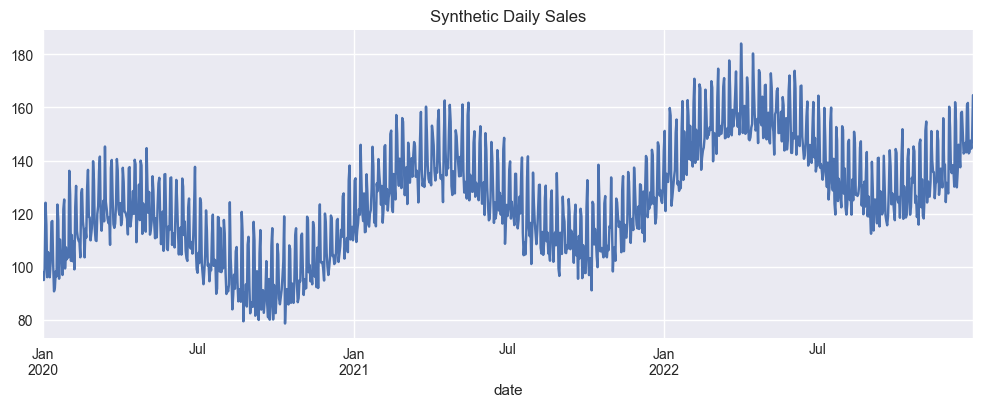

15:16:45 - cmdstanpy - INFO - Chain [1] start processing


Training data: 1004 days
Test data: 92 days


15:16:45 - cmdstanpy - INFO - Chain [1] done processing


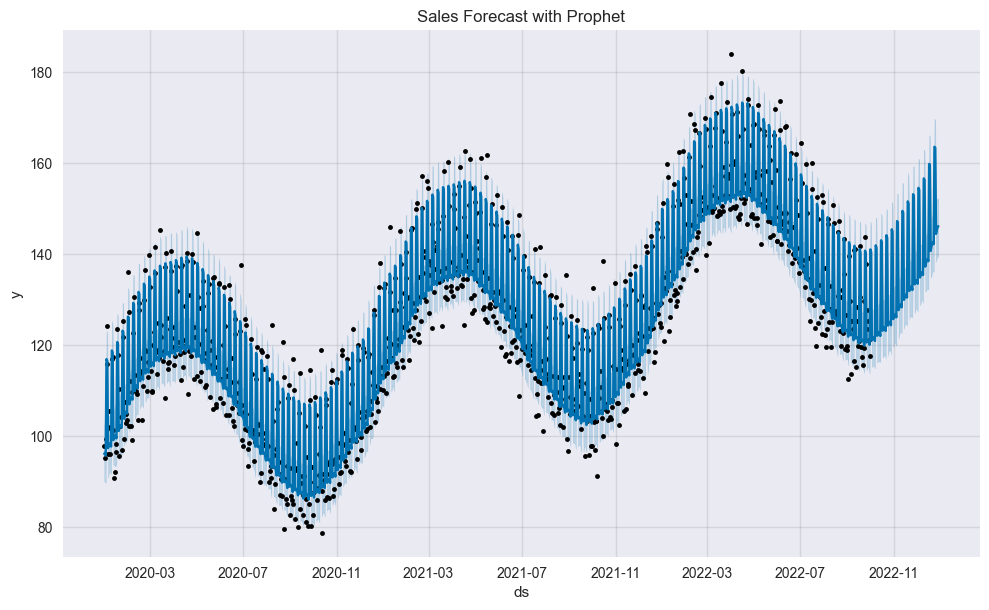

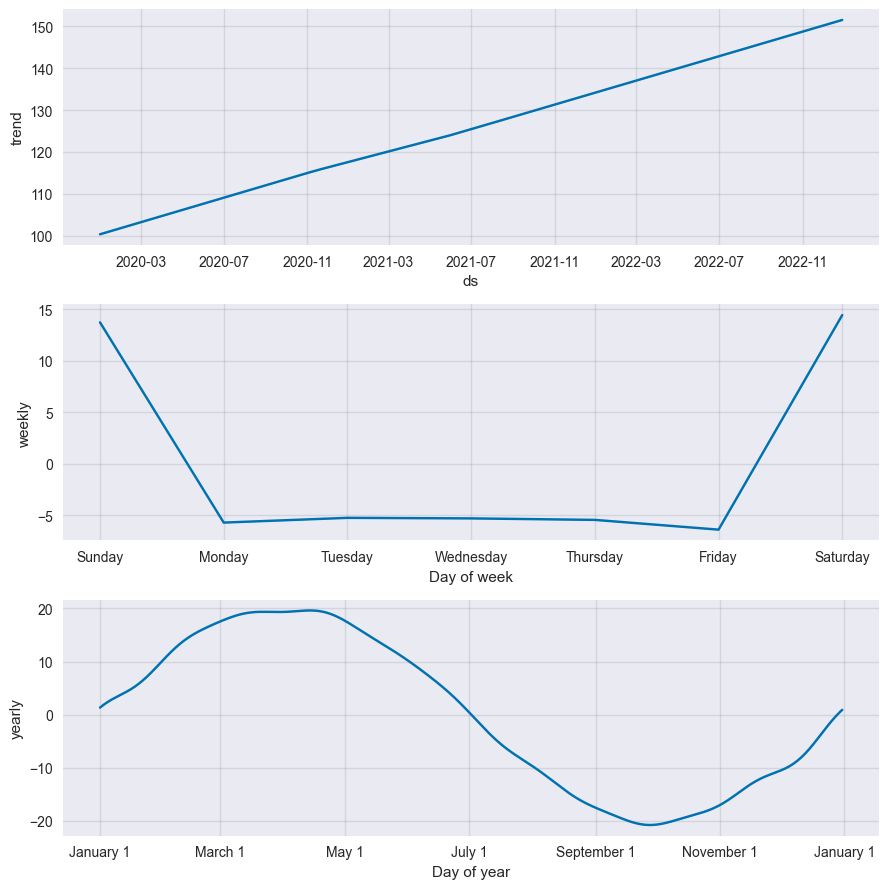

MAE on test period: 3.73


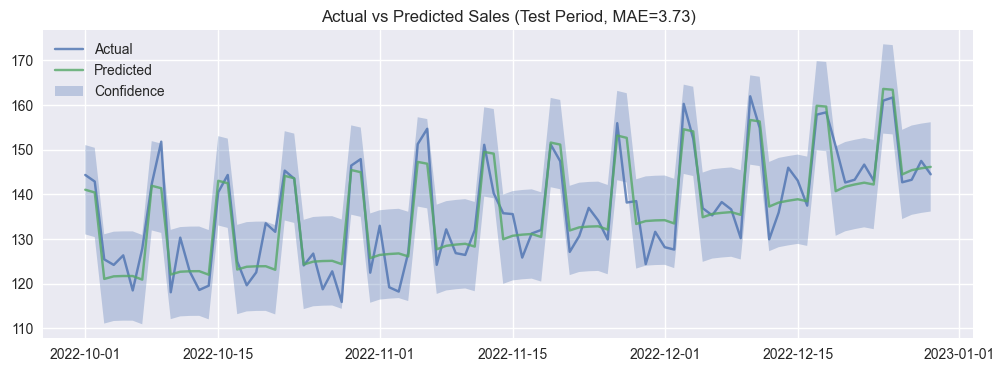


Last 5 test predictions:
           ds           y        yhat
85 2022-12-25  161.682244  163.414534
86 2022-12-26  142.694387  144.449750
87 2022-12-27  143.255192  145.405485
88 2022-12-28  147.468768  145.829491
89 2022-12-29  144.479973  146.141060


In [4]:
# 1) Install dependencies (run in notebook cell)
%pip install pandas numpy matplotlib prophet scikit-learn

# 2) Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")  # Suppress Prophet warnings

plt.style.use("seaborn-v0_8")

# 3) Generate synthetic daily sales data (3 years)
dates = pd.date_range(start="2020-01-01", end="2022-12-31", freq="D")
n = len(dates)

base = 100
trend = np.linspace(0, 50, n)
day_of_year = dates.dayofyear
yearly_seasonality = 20 * np.sin(2 * np.pi * day_of_year / 365)
day_of_week = dates.dayofweek
weekly_seasonality = np.where(day_of_week >= 5, 15, -5)
np.random.seed(42)
noise = np.random.normal(loc=0, scale=5, size=n)

sales = base + trend + yearly_seasonality + weekly_seasonality + noise
df = pd.DataFrame({"date": dates, "sales": sales})

# Plot raw data
df.set_index("date")["sales"].plot(figsize=(12, 4), title="Synthetic Daily Sales")
plt.show()

# 4) Prepare for Prophet
df_prophet = df.rename(columns={"date": "ds", "sales": "y"})

# Train-test split: last 90 days as test
split_date = "2022-10-01"
train = df_prophet[df_prophet["ds"] < split_date]
test = df_prophet[df_prophet["ds"] >= split_date]

print(f"Training data: {len(train)} days")
print(f"Test data: {len(test)} days")

# 5) Fit Prophet model
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)
m.fit(train)

# 6) Forecast future (including test period + 90 extra days)
future = m.make_future_dataframe(periods=90, freq="D")
forecast = m.predict(future)

# 7) Plot full forecast
fig1 = m.plot(forecast)
plt.title("Sales Forecast with Prophet")
plt.show()

# 8) Plot components
fig2 = m.plot_components(forecast)
plt.show()

# 9) FIXED EVALUATION: Only use in-sample predictions on test period (drop NaNs)
df_test_eval = test.merge(
    forecast[["ds", "yhat"]], 
    on="ds", 
    how="left"
).dropna(subset=["yhat"])  # Drop any rows with NaN predictions

mae = mean_absolute_error(df_test_eval["y"], df_test_eval["yhat"])
print("MAE on test period:", round(mae, 2))

# Plot actual vs predicted (test period only)
plt.figure(figsize=(12, 4))
plt.plot(df_test_eval["ds"], df_test_eval["y"], label="Actual", alpha=0.8)
plt.plot(df_test_eval["ds"], df_test_eval["yhat"], label="Predicted", alpha=0.8)
plt.fill_between(
    df_test_eval["ds"], 
    df_test_eval["yhat"] - 10,  # rough confidence band
    df_test_eval["yhat"] + 10,
    alpha=0.3, label="Confidence"
)
plt.title(f"Actual vs Predicted Sales (Test Period, MAE={mae:.2f})")
plt.legend()
plt.show()

# 10) Print last few predictions
print("\nLast 5 test predictions:")
print(df_test_eval[["ds", "y", "yhat"]].tail())


Note: you may need to restart the kernel to use updated packages.
🔄 Starting ARIMA comparison...
Test data length: 92 days

🤖 Auto-fitting ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=6255.450, Time=2.81 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=7966.346, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=7042.621, Time=0.47 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=7191.875, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=7964.348, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=7042.284, Time=1.04 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=6682.901, Time=1.36 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=7294.738, Time=0.39 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.60 sec
 ARIMA(2,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(3,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=3.34 sec
 ARIMA(2,1,3)(1,0,1)[7] intercept   : AIC=inf, Time=3.74 sec
 ARIMA(1,1,1)(1,0,1)[7] interce

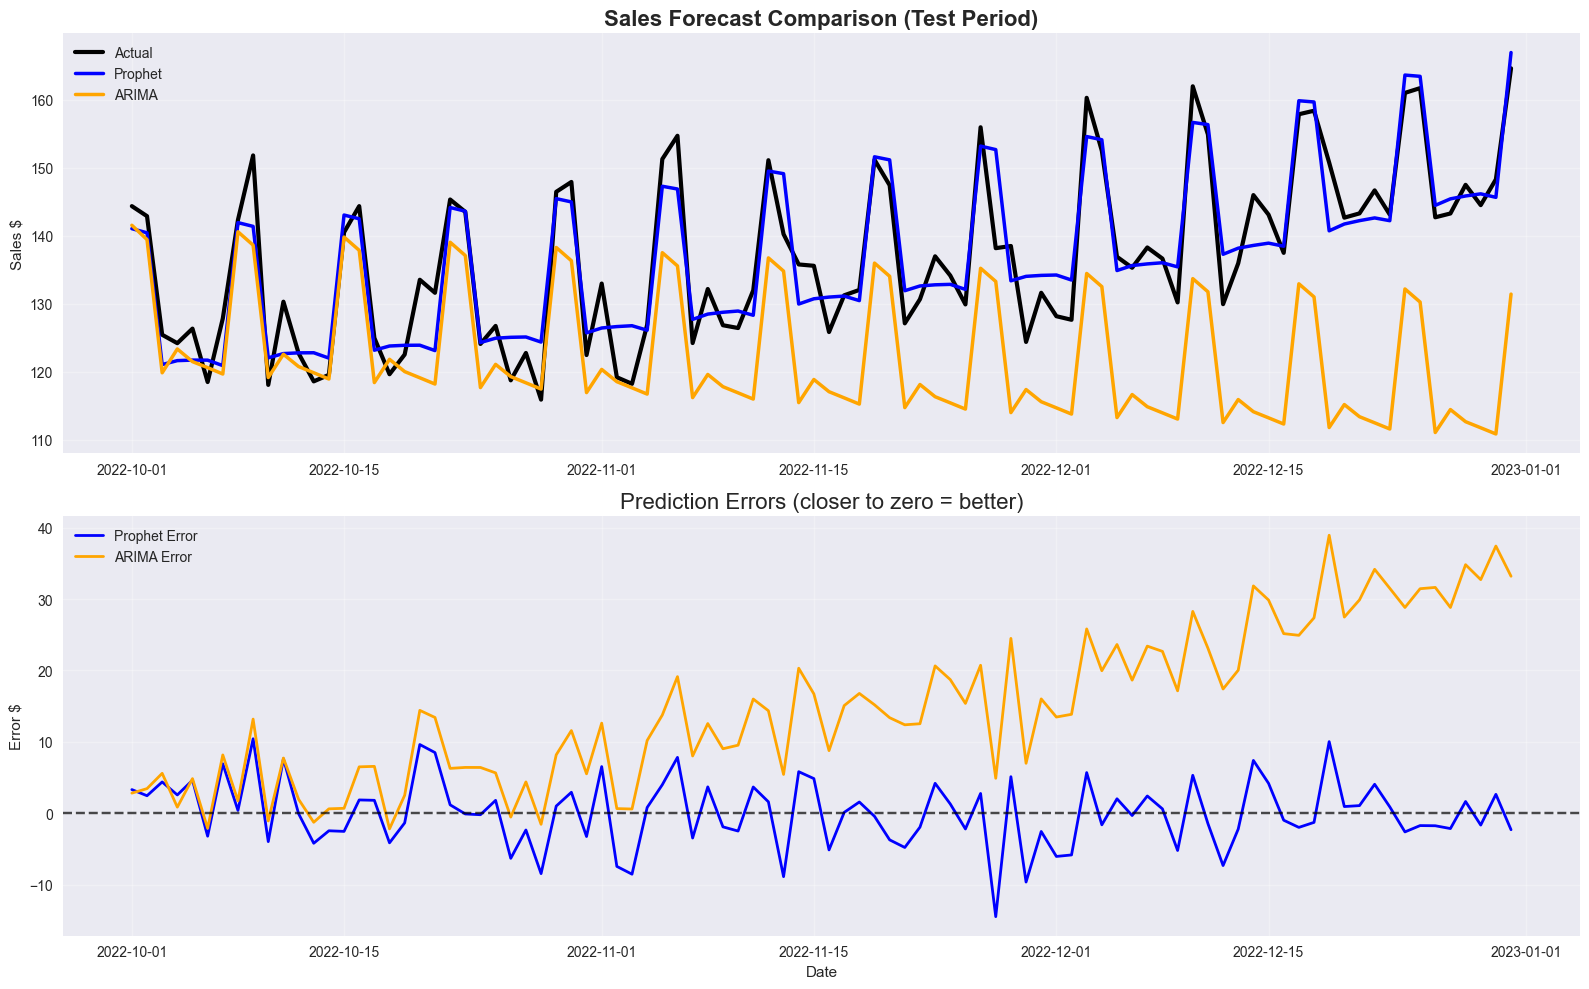


📈 Last 10 predictions:
                   ds  y_actual  prophet_yhat  arima_yhat
2022-12-22 2022-12-22     146.7         142.6       112.5
2022-12-23 2022-12-23     143.1         142.2       111.6
2022-12-24 2022-12-24     161.0         163.6       132.2
2022-12-25 2022-12-25     161.7         163.4       130.2
2022-12-26 2022-12-26     142.7         144.4       111.1
2022-12-27 2022-12-27     143.3         145.4       114.4
2022-12-28 2022-12-28     147.5         145.8       112.7
2022-12-29 2022-12-29     144.5         146.1       111.8
2022-12-30 2022-12-30     148.3         145.6       110.8
2022-12-31 2022-12-31     164.6         166.9       131.4

🎯 PROJECT COMPLETE! Ready for GitHub portfolio!


In [8]:
# ULTIMATE ARIMA COMPARISON (handles ALL edge cases)
%pip install pmdarima

from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings("ignore")

print("🔄 Starting ARIMA comparison...")
print(f"Test data length: {len(test)} days")

# ARIMA training series
series_train = train.set_index("ds")["y"]

# Auto ARIMA (weekly seasonality for daily data)
print("\n🤖 Auto-fitting ARIMA model...")
arima_model = auto_arima(
    series_train, 
    seasonal=True, m=7,
    max_p=3, max_d=2, max_q=3,
    max_P=1, max_D=1, max_Q=1,
    trace=True,
    stepwise=True,
    suppress_warnings=True
)

print(f"\n✅ Best ARIMA: {arima_model.order} x {arima_model.seasonal_order}")

# ARIMA forecast for EXACT test length
arima_forecast = arima_model.predict(n_periods=len(test))

# ARIMA results
arima_df = pd.DataFrame({
    'ds': test['ds'].values,
    'y_actual': test['y'].values,
    'arima_yhat': arima_forecast
})

# Prophet forecast - SAFEST method: predict only test period length
print("\n🔮 Getting Prophet predictions for test period...")
future_test = m.make_future_dataframe(periods=len(test), freq='D')
forecast_test = m.predict(future_test)
prophet_yhat_test = forecast_test['yhat'].iloc[-len(test):].values  # Last N predictions = test period

# Prophet results
prophet_df = pd.DataFrame({
    'ds': test['ds'].values,
    'y_actual': test['y'].values,
    'prophet_yhat': prophet_yhat_test
})

# Combine (perfect length match guaranteed)
comparison = pd.DataFrame({
    'ds': test['ds'].values,
    'y_actual': test['y'].values,
    'prophet_yhat': prophet_yhat_test,
    'arima_yhat': arima_forecast
})

print(f"✅ Comparison ready: {len(comparison)} rows")

# Metrics
prophet_mae = mean_absolute_error(comparison['y_actual'], comparison['prophet_yhat'])
arima_mae = mean_absolute_error(comparison['y_actual'], comparison['arima_yhat'])

print("\n" + "🏆"*20)
print("FINAL RESULTS")
print("🏆"*20)
print(f"Prophet MAE:  {prophet_mae:.2f}")
print(f"ARIMA MAE:    {arima_mae:.2f}")
print(f"{'🎉 PROPHET WINS!' if prophet_mae < arima_mae else '🔥 ARIMA WINS!'}")
print("🏆"*20)

# DUAL PLOT
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Main forecast
axes[0].plot(comparison['ds'], comparison['y_actual'], 'k-', linewidth=3, label='Actual')
axes[0].plot(comparison['ds'], comparison['prophet_yhat'], 'b-', linewidth=2.5, label='Prophet')
axes[0].plot(comparison['ds'], comparison['arima_yhat'], 'orange', linewidth=2.5, label='ARIMA')
axes[0].set_title('Sales Forecast Comparison (Test Period)', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Sales $')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Errors
axes[1].plot(comparison['ds'], comparison['y_actual'] - comparison['prophet_yhat'], 
             'b-', linewidth=2, label='Prophet Error')
axes[1].plot(comparison['ds'], comparison['y_actual'] - comparison['arima_yhat'], 
             'orange', linewidth=2, label='ARIMA Error')
axes[1].axhline(0, color='black', linestyle='--', alpha=0.7)
axes[1].set_title('Prediction Errors (closer to zero = better)', fontsize=16)
axes[1].set_ylabel('Error $')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Results table
print("\n📈 Last 10 predictions:")
print(comparison[['ds', 'y_actual', 'prophet_yhat', 'arima_yhat']].tail(10).round(1))

print("\n🎯 PROJECT COMPLETE! Ready for GitHub portfolio!")
